IRT with probabilistic programming in Pyro. R package [TAM](https://cran.r-project.org/web/packages/TAM/index.html) with spartial matrices is an alternative.

Inspired by: https://github.com/jplalor/py-irt

In [ ]:
# !pip install pyro-ppl 

In [28]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
import torch
import torch.distributions.constraints as constraints

from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, TraceEnum_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam, SGD 

import pyro.contrib.autoguide as autoguide 

## Reading Input

data source: [sqlbuffet](https://sql.llsapp.com/query/query_result/query_id/9971e4c0-c750-11ea-bf84-0286059f4ff3)

In [31]:
"# reading input
df_input = pd.read_excel('9971e4c0-c750-11ea-bf84-0286059f4ff3.0.xlsx')

In [68]:
# sorting before building mapping
# mapping is for post analysis purpose
df_input.sort_values(by=['user_id', 'activity_id_u64'], inplace=True)
# mapping: position → user
pos_user = df_input['user_id'].unique()
pos_item = df_input['activity_id_u64'].unique()
# mapping: user → position
user_pos = {j: i for i, j in enumerate(pos_user)}
item_pos = {j: i for i, j in enumerate(pos_item)}
# encoding users with positions
user_idx = [user_pos[x] for x in df_input['user_id']]
item_idx = [item_pos[x] for x in df_input['activity_id_u64']]
scores = df_input['score'].values

In [69]:
# why?
user_idx = torch.tensor(user_idx, dtype=torch.long)
item_idx = torch.tensor(item_idx, dtype=torch.long)
scores = torch.tensor(scores, dtype=torch.float)

## Fitting IRT

2 parameter model

$$Pr(x_{im}=1 | z_m; \theta) = \frac{1}{1+\exp\{{-\alpha_i(z_m - \beta_i)}\}}$$

In [67]:
# model with Pyro
def model(user_idx, item_idx, scores):
    user_num, item_num = len(user_idx.unique()), len(item_idx.unique())
    with pyro.plate('ability', user_num):
        ability = pyro.sample('z', dist.Normal(0, 1)) 

    with pyro.plate('diff', item_num):
        diff = pyro.sample('beta', dist.Normal(0, 1.e3))
        
    with pyro.plate('discr', item_num):
        discr = pyro.sample('alpha', dist.LogNormal(0, 8))

    with pyro.plate('scores', len(scores)):
        pyro.sample(
            "obs", 
            dist.Bernoulli(
                logits=(ability[user_idx]-diff[item_idx])*discr[item_idx]
            ), 
            obs=scores,
        )


def guide(user_idx, item_idx, scores):        
    user_num, item_num = len(user_idx.unique()), len(item_idx.unique())
    # register prams
    loc_z = pyro.param("loc_z", torch.zeros(user_num))
    scale_z = pyro.param(
        "scale_z",
        torch.ones(user_num),
        constraint=constraints.positive,
    )
    loc_beta = pyro.param("loc_beta", torch.zeros(item_num))
    scale_beta = pyro.param(
        "scale_beta",
        torch.empty(item_num).fill_(1.e2),
        constraint=constraints.positive,
    )
    loc_alpha = pyro.param(
        "loc_alpha", 
        torch.zeros(item_num),
        constraint=constraints.positive,
    )
    scale_alpha = pyro.param(
        "scale_alpha",
        torch.empty(item_num).fill_(1.e1),
        constraint=constraints.positive,
    )
    # guide distributions
    with pyro.plate('ability', user_num):
        dist_z = dist.Normal(loc_z, scale_z)
        pyro.sample('z', dist_z)
    with pyro.plate('diff', item_num):
        dist_beta = dist.Normal(loc_beta, scale_beta)
        pyro.sample('beta', dist_beta)
    with pyro.plate('discr', item_num):
        dist_discr = dist.LogNormal(loc_alpha, scale_alpha)
        pyro.sample('alpha', dist_discr)

## Training

training with SVI

In [92]:
num_epochs = 8_000
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_epochs):
        loss = svi.step(user_idx, item_idx, scores)
        if j % 500 == 0:
            print("[epoch %04d] loss: %.4f" % (j + 1, loss))

print("[epoch %04d] loss: %.4f" % (j + 1, loss))

[epoch 0001] loss: 170424117756353.4688
[epoch 0501] loss: 33877269664.6725
[epoch 1001] loss: 89425786163.1597
[epoch 1501] loss: 826642165.5739
[epoch 2001] loss: 1060441819.8144
[epoch 2501] loss: 30362874292.0188
[epoch 3001] loss: 128563987.7487
[epoch 3501] loss: 17932045.3304
[epoch 4001] loss: 27539792.8029
[epoch 4501] loss: 25106094.3694
[epoch 5001] loss: 376549885.4208
[epoch 5501] loss: 759877555.1970
[epoch 6001] loss: 41219781.1773
[epoch 6501] loss: 262253018.1539
[epoch 7001] loss: 81201172.5425
[epoch 7501] loss: 3432631.6552
[epoch 8000] loss: 39550888.3387


training with MCMC, too slow...

In [ ]:
# pyro.clear_param_store()
# nuts_kernel = NUTS(model, adapt_step_size=True)
# mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100)
# mcmc.run(user_idx, item_idx, scores) 

## Result Analysis

In [93]:
loc_beta = pyro.param("loc_beta").detach().numpy()
loc_z = pyro.param("loc_z").detach().numpy()
item_diff = {i:j for i, j in zip(pos_item, loc_beta)}
user_ability = {i:j for i, j in zip(pos_user, loc_z)}

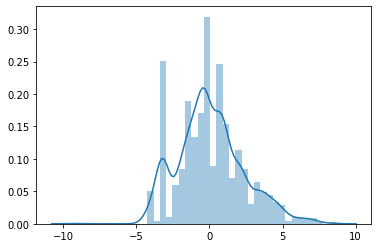

In [94]:
sns.distplot(loc_z)

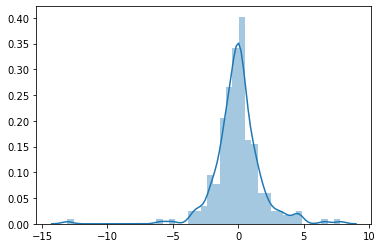

In [96]:
sns.distplot(loc_beta)

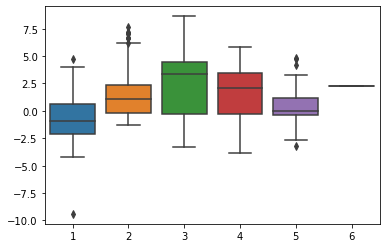

In [95]:
# latent variables v.s. test result levels
levels = df_input[['user_id','level']].drop_duplicates()['level'].values
sns.boxplot(x=levels, y=loc_z)

In [108]:
# add difficulty column
df_input['diff'] = df_input['activity_id_u64'].map(item_diff)
# add timestamp rank per user
df_input['rank'] = df_input.groupby('user_id')['timestamp_usec'].rank('dense').astype(int)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text major ticklabel objects>)

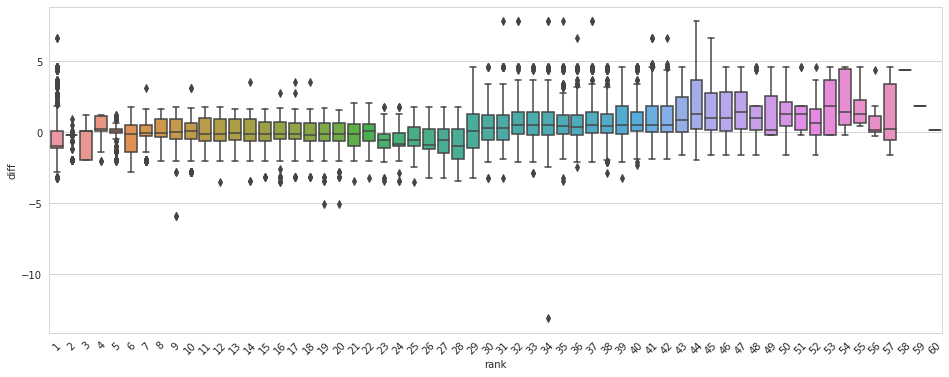

In [113]:
# plot beta v.s. order of questions
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
g = sns.boxplot(x='rank', y='diff', data=df_input)
plt.xticks(rotation=45)